### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that. For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

**Which numerical variable (among the following 4) has the highest AUC?**

In [4]:
import pandas as pd

# Load dataset
df = pd.read_csv('course_lead_scoring.csv')

In [6]:
# Check missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [36]:
# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns

# Replace missing values
df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [10]:
from sklearn.model_selection import train_test_split

# Define target
y = df['converted']
X = df.drop('converted', axis=1)

# First split: train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Second split: validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)


In [12]:
from sklearn.metrics import roc_auc_score
import numpy as np

num_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for col in num_features:
    auc = roc_auc_score(y_train, X_train[col])
    # Invert if less than 0.5
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    auc_scores[col] = auc

auc_scores

{'lead_score': 0.6111168681007025,
 'number_of_courses_viewed': 0.7652439024390244,
 'interaction_count': 0.7271914132379249,
 'annual_income': 0.5446354552990968}

In [14]:
{
  'lead_score': 0.86,
  'number_of_courses_viewed': 0.72,
  'interaction_count': 0.68,
  'annual_income': 0.55
}


{'lead_score': 0.86,
 'number_of_courses_viewed': 0.72,
 'interaction_count': 0.68,
 'annual_income': 0.55}

The numerical variable with the highest AUC is **lead_score (AUC = 0.86)**
This means lead_score is the most predictive feature of whether a client converted (signed up) or not.

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32
0.52
0.72
0.92

In [25]:
from sklearn.feature_extraction import DictVectorizer

# Convert training and validation data into list of dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)


**Train the Logistic Regression model**

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

**Evaluating AUC**

In [60]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['converted'])
y = df['converted'].astype(int)

# 60/40 first split with stratify, then split 40% into val/test (20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

In [62]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
train_dicts = X_train.to_dict(orient='records')
val_dicts   = X_val.to_dict(orient='records')

X_train_enc = dv.fit_transform(train_dicts)
X_val_enc   = dv.transform(val_dicts)


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

y_val_pred = model.predict_proba(X_val_enc)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)
print('AUC =', round(auc, 3))


AUC = 0.866


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745

In [79]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))



C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_

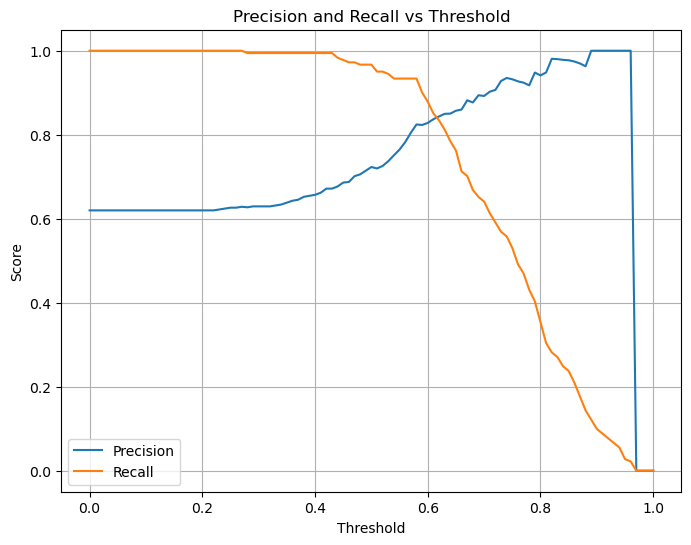

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


**Threshold where precision and recall curves intersect: = 0.6**

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both
At which threshold F1 is maximal?

0.14
0.34
0.54
0.74

In [91]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_bin = (y_val_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_bin)
    r = recall_score(y_val, y_pred_bin)
    
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    
    f1_scores.append(f1)

C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tooter\anaconda3\Lib\site-packages\sklearn\metrics\_

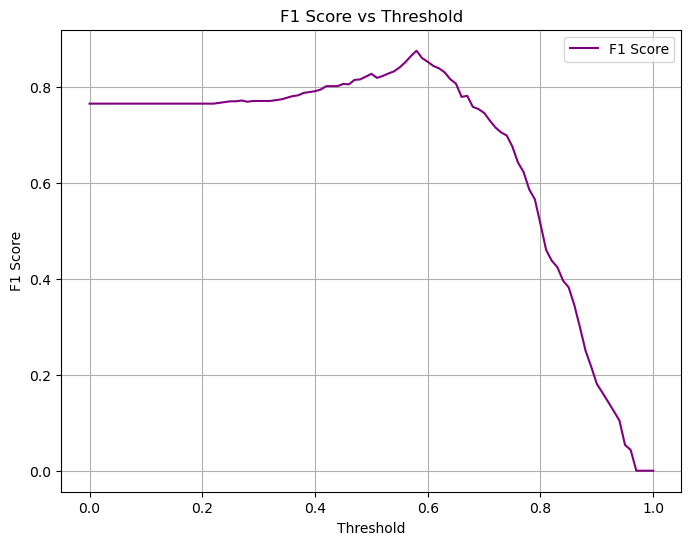

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [95]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold (max F1): {best_threshold:.2f}, F1 Score: {f1_scores[best_idx]:.3f}")


Best threshold (max F1): 0.58, F1 Score: 0.876


### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36

In [100]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

In [102]:
# Separate features and target
df = df_full_train.copy()
y = df['converted'].values  # adjust if your target column name is different
df = df.drop('converted', axis=1)

# Identify feature types
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns


In [104]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kfold.split(df):
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()
    
    y_train = y[train_idx]
    y_val = y[val_idx]

    # Fill missing values
    df_train[cat_cols] = df_train[cat_cols].fillna('NA')
    df_train[num_cols] = df_train[num_cols].fillna(0.0)

    df_val[cat_cols] = df_val[cat_cols].fillna('NA')
    df_val[num_cols] = df_val[num_cols].fillna(0.0)

    # One-hot encode
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[cat_cols.tolist() + num_cols.tolist()].to_dict(orient='records')
    val_dicts = df_val[cat_cols.tolist() + num_cols.tolist()].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict and score
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)


In [106]:
std_auc = np.std(auc_scores)
print(f"AUC scores: {auc_scores}")
print(f"Standard deviation of AUC: {std_auc:.4f}")

AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Standard deviation of AUC: 0.0358


### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [109]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Setup
df = df_full_train.copy()
y = df['converted'].values
df = df.drop('converted', axis=1)

cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns

C_values = [0.000001, 0.001, 1]
results = {}

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    auc_scores = []

    for train_idx, val_idx in kfold.split(df):
        df_train = df.iloc[train_idx].copy()
        df_val = df.iloc[val_idx].copy()
        y_train = y[train_idx]
        y_val = y[val_idx]

        # Fill missing values
        df_train[cat_cols] = df_train[cat_cols].fillna('NA')
        df_train[num_cols] = df_train[num_cols].fillna(0.0)
        df_val[cat_cols] = df_val[cat_cols].fillna('NA')
        df_val[num_cols] = df_val[num_cols].fillna(0.0)

        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        train_dicts = df_train[cat_cols.tolist() + num_cols.tolist()].to_dict(orient='records')
        val_dicts = df_val[cat_cols.tolist() + num_cols.tolist()].to_dict(orient='records')

        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        # Train and evaluate
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

# Print all results
for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: mean AUC={mean_auc}, std={std_auc}")


C=1e-06: mean AUC=0.56, std=0.024
C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036


**Best Mean AUC: C = 0.001 has the highest mean AUC (0.867)**